<h1 align = 'center'>Guessing Games</h1>
<h3 align = 'center'>machine learning, one step at a time</h3>
<h3 align = 'center'>Step 5. Going Uphill</h3>

#### 5. Let's try to play the dice game.

Remember: these are the rules:
<ul>
<li>the maximum score is 20
<li>roll a pair of dice, add them up, that's your score
<li>decide if you want to roll **both dice** again... if you do, add the roll to your score
<li>get as close as you can to a total of 20...
<li>but if you go over 20, your score is zero.
</ul>

Here is our function to roll a specified number of dice:

In [1]:
import random

def roll_dice(number_of_dice):
    
    sum = 0
    
    for i in range(0, number_of_dice):
        sum += random.randrange(6)+1     # randrange is 0 through 5, so add 1 to get a six-sided die roll
    return sum


roll_dice(2)

7

The key to the game is deciding when to roll (again) without going over the maximum score.

So for any score, the program needs to guess whether rolling again is a good idea.

In [2]:
def play(value):                      # the 'value' is the score above which the player stops rolling
    
    total_score = roll_dice(2)        # start by rolling two dice
    
    while total_score <= value:       # if the score is at or under the value...
        total_score += roll_dice(2)   # roll again, and add to score
        
    if total_score <= 20:
        return total_score            # if total is 20 or less, that's your score...
    else:
        return 0                      #  but if you go over 20, your score is zero.

Just for fun, let's say that we decide to roll if our total is less than 15, and we play 10 times:

In [3]:
for i in range(0,10):
    print(play(15))

17
18
18
17
16
0
19
16
16
18


There's a pretty good chance that we won some, and we lost some. It's probably not the best way to play... but hey, we did not put in a lot of effort... we just picked the value of 15 arbitrarily.

How could we use machine learning to find the optimum value?

For starters, let's try to understand the relationship between the value and the resulting score, using data visualization:

In [4]:
import matplotlib.pyplot as plt

values = []
scores = []
    
for value in range(1,21):            # for every value from 1 to 20...
    for i in range(1,10):            # play the games 10 times...
        values.append(value)         # and record the value and the score
        scores.append(play(value))

plt.plot(values,scores,'o')

(Take a good look at the dots)

Those dots suggest that higher values lead to higher scores, but if the value is too high, you might just score zero

How about plotting eachg value versus its average score?

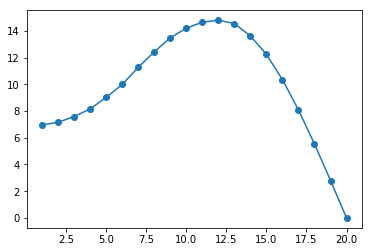

In [5]:
values = []
scores = []
tries = 10000

def average_score(value, tries):
    total_score = 0
    for i in range(0,tries):
        total_score += play(value)                # add up all the scores...
    return total_score / tries                    # ...then divide by the number of games played
        
for value in range(1,21):                         # make lists for values and total scores
    values.append(value)
    scores.append(0)

for value in range(1,21):
    scores[value-1] = average_score(value,tries)  # accumulate the total score in list of scores

plt.plot(values,scores,'o-')

Looks like the highest average score is around 14 or 15, using a value of around 13.

Could a program find the optimum value to get the highest average score, if we set it up to guess, then learn from its mistakes?

(if you guessed 'that's the point of the lesson', you would be right)

Let's imagine we know nothing about the game, and we start by guessing a value of 7:

In [6]:
average_score(7,10000)

11.278

The average score is somewhere around 11... how do we judge if that is a good score?

Or: **where do we get a hint, when we need one?**

Let's manufacture our own hint. Try moving one space to the left of 7, and then one space to the right of 7, and seeing how those results compare to each other:

In [7]:
left = average_score(7 - 1, 100000)
right = average_score(7 + 1, 100000)
print(left, right)

9.99019 12.42239


We created a **hint**: it looks like moving to the left makes things worse (the score goes down), while moving to the right makes things better (the score goes up). In terms of a graph, **the slope is upward** for a value of 7:

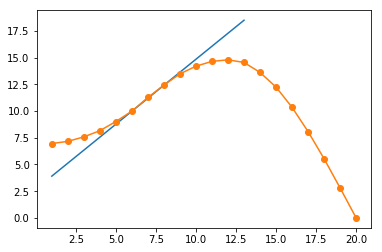

In [8]:
# feel free to ignore these details... we are drawing a line, and aligning it with the prior results
m = (right - left)/2                    # find the slope
b = left-(m*7)                          # find the intercept
x = [1,13]                              # pick endpoints
y = [m * (xi+1) + b for xi in x]        # compute y values (the +1 is to align with prior results)
plt.plot(x,y,'-',values,scores,'o-')    # plot the line along with the prior results

To make the score higher, starting with a value of 7... go up the hill! (ie, move to the right).

How about a value of 16?

It's the same drill:

In [9]:
left1 = average_score(16 - 1, 100000)
right1 = average_score(16 + 1, 100000)
print(left1, right1)

12.21538 8.10411


This time, the slope is **downward**:

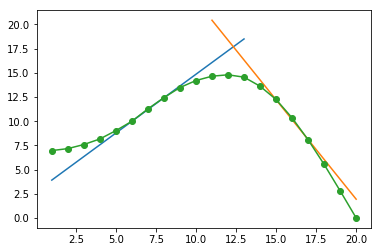

In [10]:
m1 = (right1 - left1)/2                 # find the slope
b1 = left1-(m1*16)                      # find the intercept
x1 = [11,20]                            # pick endpoints
y1 = [m1 * (xi+1) + b1 for xi in x1]    # compute y values (the +1 is to align with prior results)
plt.plot(x,y,'-',x1,y1,'-',values,scores,'o-')

It stands to reason that we can manufacture hints anywhere along the curve, and use those hints to tell us which way to go. If the slope is positive, move to the right (increase the value in proportion to the slope). If the slope is negative, move to the left (decrease the value in proportion to the slope). Move a little at a time, and when the slope stops changing (more or less), that's the best value:

In [37]:
def get_slope(value):
    return (average_score(value+1,10000)-average_score(value-1,10000))/2

def get_value_for_maximum_score(value):
    m = 999
    while abs(m) > 0.10:             # while the slope is not close to zero
        m = get_slope(value)         # compute the slope
        value += m * 0.05            # update the value by using the slope as a hint
    return value

wild_guess = random.random() * 18 + 2
print(get_value_for_maximum_score(wild_guess))


12.972325115133149


I get values between 12 and 13, and it takes about 20 or 30 seconds to run.